In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv('../data/SBAnational.csv')
df.head(1)

/var/folders/41/hgg8f6_j1dj4y4mt0w22d8ym0000gn/T/ipykernel_80843/4085732375.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/SBAnational.csv')


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"


In [3]:
# I'm gonna drop a bumch of columns that I don't care about for now.
drop_columns = ['Name', 'LoanNr_ChkDgt', 'Zip','BankState',
                'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
                'BalanceGross', 'ChgOffPrinGr']
df.drop(drop_columns, inplace=True, axis=1)
df.head(1)

,City,State,Bank,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv
0,EVANSVILLE,IN,FIFTH THIRD BANK,451120,28-Feb-97,1997,84,4,2.000,0,0,1,0,N,Y,P I F,"$60,000.00","$48,000.00"


In [4]:
features = []
target = 'Default'


In [5]:
# Helper function to draw histograms
def draw_histogram(column: pd.DataFrame, name: str, nbins: int = 50, log=False):
    plt.figure(figsize=(8, 6))
    plt.hist(column, bins=nbins, alpha=0.7, color='skyblue', edgecolor='black', log=log)
    plt.title(f'Histogram of {name}')
    plt.xlabel(name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Feature exploration!

### Target
The target will be binary encoded, 1 representing a defaulted loand and 0 the case of full payment.

In [6]:
# Drop data with null MIS_Status, as it is useless
df.dropna(subset=['MIS_Status'], inplace=True)
df['MIS_Status'].describe()

count     897167
unique         2
top        P I F
freq      739609
Name: MIS_Status, dtype: object

In [7]:
# Encode the target variable to binary values. This will encode Default as 1, 
# which in my opinion makes everything more intuitive.

df[target] = np.where(df['MIS_Status'] == 'CHGOFF', 1, 0)
df[target].describe()

count   897167.000
mean         0.176
std          0.380
min          0.000
25%          0.000
50%          0.000
75%          0.000
max          1.000
Name: Default, dtype: float64

### City, State, Bank, ApprovalFY, NoEmp, CreateJob, RetainedJob
Testing

In [8]:
testing = ['City', 'State', 'Bank', 'ApprovalFY', 'NoEmp', 'CreateJob', 'RetainedJob', 'ApprovalDate']

### NAICS
North American Industry Classification System code\
See [census](https://www.census.gov/naics/?58967?yearbck=2012) for identifying the industries. Note: It's the 2002 naming for some reason, not the 2012 one. Probably they are even mixed.
<mark>TODO: Identify most common industries.</mark> \



In [9]:
top_naics = df['NAICS'].value_counts().head()
print(f"\nThe top 5 most common NAICS:")
top_naics


The top 5 most common NAICS:


NAICS
0         201667
722110     27941
722211     19435
811111     14539
621210     14034
Name: count, dtype: int64

We will only take a look at the first two digits of NAICS, which encode the broad industry.

In [10]:
## Convert NAICS to a string to make easier getting two digits.
df['NAICS'] = df['NAICS'].astype(str)

## Get only first two digits of NAICS, an convert it back to integer.
def NAICS_conversion(naics_string):
    return int(naics_string[:2])

df['NAICS_i'] = df['NAICS'].apply(NAICS_conversion).astype(int)

In [11]:
# Change to a string to get categorical descriptions.
df['NAICS'] = df['NAICS'].astype(str)
df['NAICS'].describe()

count     897167
unique      1312
top            0
freq      201667
Name: NAICS, dtype: object

In [12]:
df['NAICS_i'].value_counts().head(5)

NAICS_i
0     201667
44     84567
81     72395
54     67922
72     67511
Name: count, dtype: int64

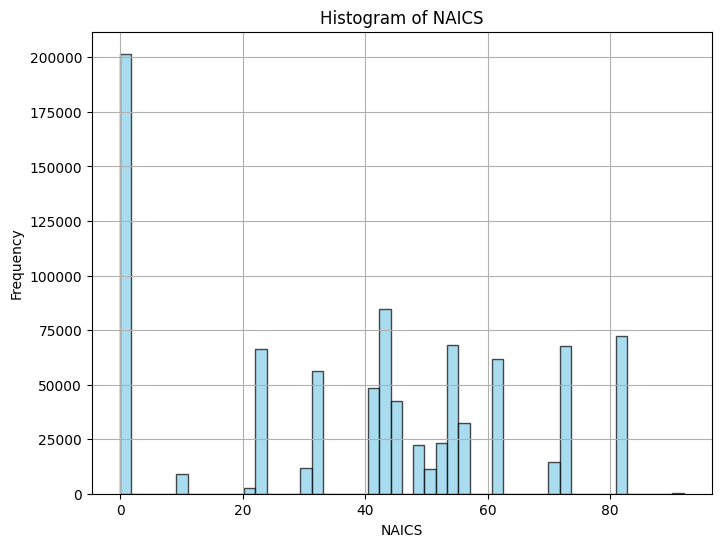

In [13]:
draw_histogram(df['NAICS_i'], "NAICS")

In [14]:
features.append('NAICS_i')
testing.append('NAICS')

### Term
Loan term in months

In [15]:
df['Term'].describe()

count   897167.000
mean       110.849
std         78.901
min          0.000
25%         60.000
50%         84.000
75%        120.000
max        569.000
Name: Term, dtype: float64

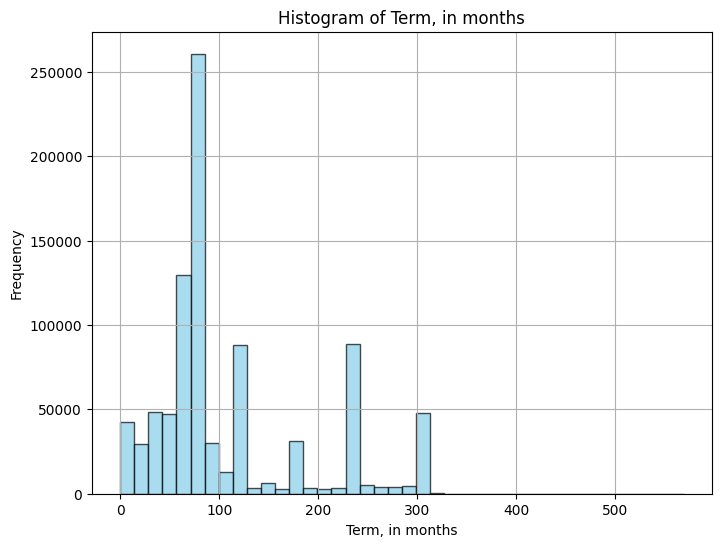

In [16]:
draw_histogram(df['Term'], 'Term, in months', 40)

In [17]:
features.append('Term')

### NewExist
1 = Existing Business, 2 = New Business\
We will change it to isNewBusiness, which is 1 when the company is of new creation.

In [18]:
df['NewExist'].value_counts()

NewExist
1.000    643446
2.000    252559
0.000      1028
Name: count, dtype: int64

In [19]:
# NewExist has samples with value 0.0 and nulls. Let's drop these.
df = df[(df['NewExist'] != 0) & (df['NewExist'].notnull())]

In [20]:
# Make a column called NewBusiness, which is 0 when NewExist is 1 and 1 when it's 2.
df['isNewBusiness'] = df['NewExist'] - 1
df['isNewBusiness'].describe()

count   896005.000
mean         0.282
std          0.450
min          0.000
25%          0.000
50%          0.000
75%          1.000
max          1.000
Name: isNewBusiness, dtype: float64

In [21]:
# Gets added as a feature
features.append('isNewBusiness')

### FranchiseCode
Franchise Code 00000 or 00001 = No Franchise\
Some values included are:\
78760: Subway\
68020: Quiznos\
50564: Mail Boxes Etc\
21780: Dairy Queen\
25650: Dunkin\
79140: Super 8

For now, we will use it as isFranchise, being 1 when a business is a franchise and 0 otherwise.

In [22]:
top_franchises = df['FranchiseCode'].value_counts().head(10)
print(f"\nThe top 10 most common franchises:")
top_franchises


The top 10 most common franchises:


FranchiseCode
1        636490
0        207863
78760      3364
68020      1918
50564      1032
21780       999
25650       714
79140       658
22470       613
17998       606
Name: count, dtype: int64

In [23]:
# Function to create the 'isFranchise' column
def is_franchise(code):
    return 0 if code in [0, 1] else 1

df['isFranchise'] = df['FranchiseCode'].apply(is_franchise)

In [24]:
df['isFranchise'].describe()

count   896005.000
mean         0.058
std          0.233
min          0.000
25%          0.000
50%          0.000
75%          0.000
max          1.000
Name: isFranchise, dtype: float64

In [25]:
# Gets added to our features
features.append('isFranchise')

### UrbanRural
1= Urban, 2= Rural, 0 = Undefined\
Each of the three options of UrbanRural (0, 1 and 2) are considered as valid inputs.

In [26]:
df['UrbanRural'] = df['UrbanRural'].astype(str)
df['UrbanRural'].describe()

count     896005
unique         3
top            1
freq      468811
Name: UrbanRural, dtype: object

In [27]:
# Gets added to our features
features.append('UrbanRural')

### RevLineCr
Revolving Line of Credit: Y = Yes\
There is a significative amount of possible values which don't have a clear meaning (i.e. 0, T, 1, R, 2, C). There are also nulls.\
We will reduce it to 1, if it is a Revolving Line of Credit, or 0 otherwise.

In [28]:
df['RevLineCr'].value_counts()

RevLineCr
N    418229
0    257375
Y    200588
T     15232
1        22
R        14
`        11
2         6
C         2
3         1
,         1
7         1
A         1
5         1
.         1
4         1
-         1
Q         1
Name: count, dtype: int64

In [29]:
# A lot of the possible values are junk. We assume that 0 and N are equivalent and drop the rest of outliers.
df['RevLineCr'] = df['RevLineCr'].replace('N', '0')
df['RevLineCr'] = df['RevLineCr'].replace('0', 0)
df['RevLineCr'] = df['RevLineCr'].replace('Y', 1)

In [30]:
df = df[df['RevLineCr'].isin([0, 1])]
df['RevLineCr'] = df['RevLineCr'].astype(int)

In [31]:
df['RevLineCr'].describe()

count   876192.000
mean         0.229
std          0.420
min          0.000
25%          0.000
50%          0.000
75%          0.000
max          1.000
Name: RevLineCr, dtype: float64

In [32]:
# Gets added to our features
features.append('RevLineCr')

### LowDoc
LowDoc Loan Program: Y = Yes, N = No\
There is a significative amount of possible values which don't have a clear meaning (i.e. 0, C, S, A, 1). There are also nulls.\
Therefore, will be 1 if the loan is part of the LowDoc program and 0 otherwise.

In [33]:
df['LowDoc'].value_counts()

LowDoc
N    762649
Y    107865
0      1238
C       752
S       599
A       491
R        73
1         1
Name: count, dtype: int64

In [34]:
# All values which are not N or Y get dropped.
df['LowDoc'] = df['LowDoc'].replace('N', 0)
df['LowDoc'] = df['LowDoc'].replace('Y', 1)

In [35]:
df = df[df['LowDoc'].isin([0, 1])]
df['LowDoc'] = df['LowDoc'].astype(int)

In [36]:
df['LowDoc'].describe()

count   870514.000
mean         0.124
std          0.329
min          0.000
25%          0.000
50%          0.000
75%          0.000
max          1.000
Name: LowDoc, dtype: float64

In [37]:
features.append('LowDoc')

### GRAppv
Gross Amount of Loan Approved by Bank\
The size of the loan will be used as a feature after being converted to float numbers.

In [38]:
#Parse dollar values to float value
def dollar_to_float(dollar_string: str):
    return float(dollar_string.replace('$','').replace(',',''))

In [39]:
df['GrAppv'] = df['GrAppv'].apply(dollar_to_float)
df['GrAppv'].describe()

count    870514.000
mean     195110.147
std      284311.192
min        1000.000
25%       35000.000
50%       94000.000
75%      230000.000
max     5000000.000
Name: GrAppv, dtype: float64

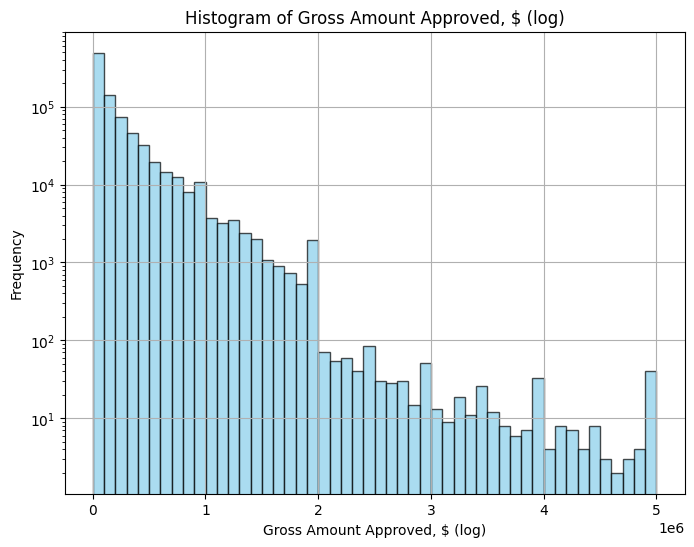

In [40]:
# I will go over the loans under $1 million.
#draw_histogram(df[df['GrAppv'] < 1000000]['GrAppv'], 'Gross Amount Approved, $', 50)
draw_histogram(df['GrAppv'], 'Gross Amount Approved, $ (log)', 50, log=True)

In [41]:
# Gets added to our features
features.append('GrAppv')

### SBA_Appv
SBA’s Guaranteed Amount of Approved Loan\
**Encoding:**\
Has to be translated into floats.

In [42]:
df['SBA_Appv'] = df['SBA_Appv'].apply(dollar_to_float)
df['SBA_Appv'].describe()

count    870514.000
mean     151475.186
std      228871.350
min         500.000
25%       22400.000
50%       63750.000
75%      177000.000
max     4500000.000
Name: SBA_Appv, dtype: float64

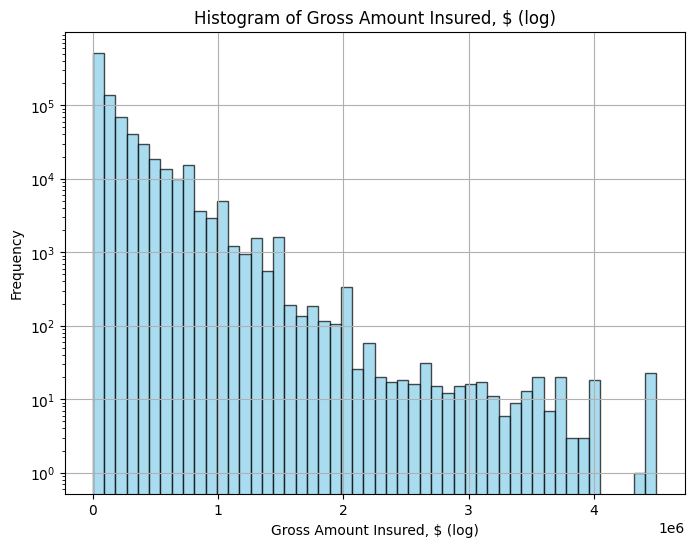

In [43]:
# I will go over the loans under $200k.

#draw_histogram(df[df['SBA_Appv'] < 200000]['SBA_Appv'], 'Gross Amount Approved, $', 50)
draw_histogram(df['SBA_Appv'], 'Gross Amount Insured, $ (log)', 50, log=True)

In [44]:
# Gets added to our features
features.append('SBA_Appv')

In [45]:
print(f"By now, our features are: {features}")
print(f"Our target is {target}")
print(f"We will test out how {testing} correlate")

By now, our features are: ['NAICS_i', 'Term', 'isNewBusiness', 'isFranchise', 'UrbanRural', 'RevLineCr', 'LowDoc', 'GrAppv', 'SBA_Appv']
Our target is Default
We will test out how ['City', 'State', 'Bank', 'ApprovalFY', 'NoEmp', 'CreateJob', 'RetainedJob', 'ApprovalDate', 'NAICS'] correlate


In [46]:
df[features].describe()

,NAICS_i,Term,isNewBusiness,isFranchise,RevLineCr,LowDoc,GrAppv,SBA_Appv
count,870514.000,870514.000,870514.000,870514.000,870514.000,870514.000,870514.000,870514.000
mean,39.514,111.509,0.282,0.058,0.229,0.124,195110.147,151475.186
std,26.365,79.177,0.450,0.235,0.420,0.329,284311.192,228871.350
min,0.000,0.000,0.000,0.000,0.000,0.000,1000.000,500.000
25%,23.000,60.000,0.000,0.000,0.000,0.000,35000.000,22400.000
50%,44.000,84.000,0.000,0.000,0.000,0.000,94000.000,63750.000
75%,56.000,120.000,1.000,0.000,0.000,0.000,230000.000,177000.000
max,92.000,569.000,1.000,1.000,1.000,1.000,5000000.000,4500000.000


# Feature engineering

In [47]:
# Engineered features array
engineering = []

### SBARatio
The percentage of loan insured by SBA

In [48]:
df['SBARatio'] = df['SBA_Appv'] / df['GrAppv']
df['SBARatio'].describe()

count   870514.000
mean         0.712
std          0.173
min          0.028
25%          0.500
50%          0.750
75%          0.850
max          1.000
Name: SBARatio, dtype: float64

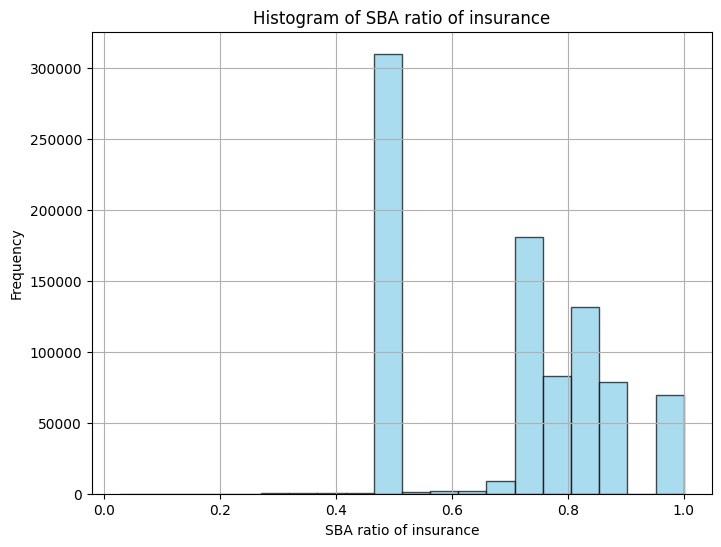

In [49]:
draw_histogram(df['SBARatio'], 'SBA ratio of insurance', 20)
# Most are located in round numbers, like 50%, 75%, 80% etc.

In [50]:
engineering.append('SBARatio')

### Interest Rate

In [51]:
# Read the data and parse dates directly while reading the CSV
interest_rates_expanded = pd.read_csv('../data/interest_rates.csv', parse_dates=['DATE'])

# Extract YEAR and MONTH using vectorized operations
interest_rates_expanded['YEAR'] = interest_rates_expanded['DATE'].dt.year
interest_rates_expanded['MONTH'] = interest_rates_expanded['DATE'].dt.month

# Drop the redundant DATE column and sort by YEAR, MONTH
interest_rates_expanded = interest_rates_expanded.drop(columns='DATE').sort_values(by=['YEAR', 'MONTH'])

# Save the generated DataFrame to a .csv file
interest_rates_expanded.to_csv('../data/interest_rates_expanded.csv', index=False)

interest_rates_expanded.head(5)

,FEDFUNDS,YEAR,MONTH
0,0.800,1954,7
1,1.220,1954,8
2,1.070,1954,9
3,0.850,1954,10
4,0.830,1954,11


In [52]:
# read the base values
df_temp = df.copy(deep=True)

# Preprocess 'ApprovalDate' column to extract 'YEAR' and 'MONTH' values
df_temp['YEAR'] = pd.to_datetime(df_temp['ApprovalDate'], format='%d-%b-%y').dt.year.astype(str)
df_temp['MONTH'] = pd.to_datetime(df_temp['ApprovalDate'], format='%d-%b-%y').dt.month.astype(str).str.zfill(2)

# Merge 'YEAR' and 'MONTH' columns into a single 'YEAR_MONTH' column for efficient comparison
df_temp['YEAR_MONTH'] = df_temp['YEAR'] + '-' + df_temp['MONTH']

# Merge interest_rates_expanded DataFrame 'YEAR' and 'MONTH' columns into a single 'YEAR_MONTH' column
interest_rates_expanded['YEAR_MONTH'] = interest_rates_expanded['YEAR'].astype(str) + '-' + interest_rates_expanded['MONTH'].astype(str).str.zfill(2)

# Merge 'InterestRate' column into df_temp based on 'YEAR_MONTH' column
df_temp = pd.merge(df_temp, interest_rates_expanded[['YEAR_MONTH', 'FEDFUNDS']], how='left', on='YEAR_MONTH')

df_temp['InterestRate'] = df_temp['FEDFUNDS']
# Using this year we don't need to clean up!!!
df_temp['ApprovalFY'] = df_temp['YEAR'].astype(int)

In [53]:
df_temp.head()

,City,State,Bank,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,...,Default,NAICS_i,isNewBusiness,isFranchise,SBARatio,YEAR,MONTH,YEAR_MONTH,FEDFUNDS,InterestRate
0,EVANSVILLE,IN,FIFTH THIRD BANK,451120,28-Feb-97,1997,84,4,2.000,0,...,0,45,1.000,0,0.800,1997,02,1997-02,5.190,5.190
1,NEW PARIS,IN,1ST SOURCE BANK,722410,28-Feb-97,1997,60,2,2.000,0,...,0,72,1.000,0,0.800,1997,02,1997-02,5.190,5.190
2,BLOOMINGTON,IN,GRANT COUNTY STATE BANK,621210,28-Feb-97,1997,180,7,1.000,0,...,0,62,0.000,0,0.750,1997,02,1997-02,5.190,5.190
3,BROKEN ARROW,OK,1ST NATL BK & TR CO OF BROKEN,0,28-Feb-97,1997,60,2,1.000,0,...,0,0,0.000,0,0.800,1997,02,1997-02,5.190,5.190
4,ORLANDO,FL,FLORIDA BUS. DEVEL CORP,0,28-Feb-97,1997,240,14,1.000,7,...,0,0,0.000,0,1.000,1997,02,1997-02,5.190,5.190


In [54]:
df = df_temp.drop(['YEAR', 'MONTH', 'YEAR_MONTH', 'FEDFUNDS'], axis=1)


In [55]:
df['InterestRate'].describe()

count   870514.000
mean         3.928
std          2.187
min          0.070
25%          1.810
50%          4.490
75%          5.310
max         19.100
Name: InterestRate, dtype: float64

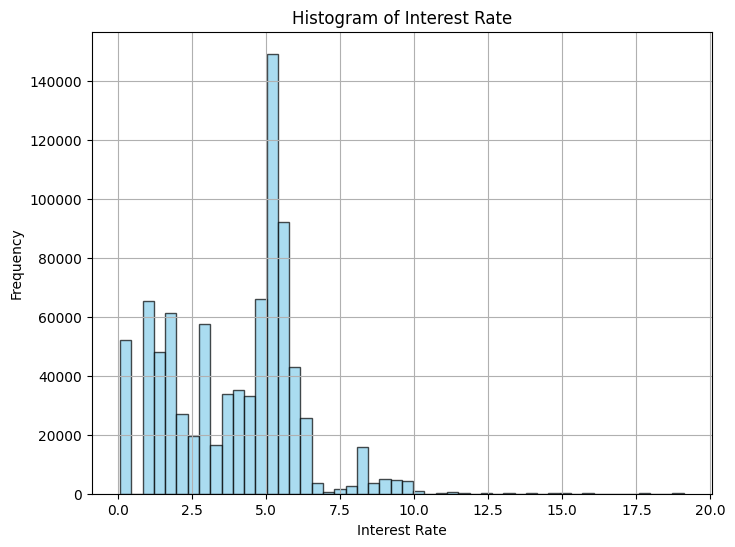

In [56]:
draw_histogram(df['InterestRate'], 'Interest Rate')

In [57]:
engineering.append('InterestRate')


In [58]:
print(f"We have engineered {engineering}!")
print(f"Our total features are {[features + engineering]}")


We have engineered ['SBARatio', 'InterestRate']!
Our total features are [['NAICS_i', 'Term', 'isNewBusiness', 'isFranchise', 'UrbanRural', 'RevLineCr', 'LowDoc', 'GrAppv', 'SBA_Appv', 'SBARatio', 'InterestRate']]


In [59]:
df[features + engineering].describe()

,NAICS_i,Term,isNewBusiness,isFranchise,RevLineCr,LowDoc,GrAppv,SBA_Appv,SBARatio,InterestRate
count,870514.000,870514.000,870514.000,870514.000,870514.000,870514.000,870514.000,870514.000,870514.000,870514.000
mean,39.514,111.509,0.282,0.058,0.229,0.124,195110.147,151475.186,0.712,3.928
std,26.365,79.177,0.450,0.235,0.420,0.329,284311.192,228871.350,0.173,2.187
min,0.000,0.000,0.000,0.000,0.000,0.000,1000.000,500.000,0.028,0.070
25%,23.000,60.000,0.000,0.000,0.000,0.000,35000.000,22400.000,0.500,1.810
50%,44.000,84.000,0.000,0.000,0.000,0.000,94000.000,63750.000,0.750,4.490
75%,56.000,120.000,1.000,0.000,0.000,0.000,230000.000,177000.000,0.850,5.310
max,92.000,569.000,1.000,1.000,1.000,1.000,5000000.000,4500000.000,1.000,19.100


In [60]:
overwritten_columns = ['ApprovalDate', 'NAICS', 'NewExist', 'MIS_Status',]
df.drop(overwritten_columns, axis=1, inplace=True)
df.head(1)

,City,State,Bank,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,GrAppv,SBA_Appv,Default,NAICS_i,isNewBusiness,isFranchise,SBARatio,InterestRate
0,EVANSVILLE,IN,FIFTH THIRD BANK,1997,84,4,0,0,1,0,0,1,60000.000,48000.000,0,45,1.000,0,0.800,5.190


In [61]:
df.to_csv('../data/data_clean.csv', index=False)

# Visualizations

From here onward we are going to explore a bunch of possible encodings and see how they relate with out target distribution.

In [62]:
print(f"We still have to explore {testing}")

We still have to explore ['City', 'State', 'Bank', 'ApprovalFY', 'NoEmp', 'CreateJob', 'RetainedJob', 'ApprovalDate', 'NAICS']


In [63]:
df_testing = df.copy(deep=True)

In [64]:
# These are features I'm not sure add value
beta_features = ['ApprovalFY']

### CityLoans, BankLoans, StateLoans

In [65]:
# If we are going to play with thee the data needs to be cleaned
df_testing.dropna(subset=['City', 'State', 'Bank'], inplace=True)

In [66]:
#Population encoding!
df_testing['CityLoans'] = df_testing.groupby('City')['City'].transform('count')
df_testing['BankLoans'] = df_testing.groupby('Bank')['Bank'].transform('count')
df_testing['StateLoans'] = df_testing.groupby('State')['State'].transform('count')

beta_features.extend(['CityLoans', 'BankLoans', 'StateLoans'])


In [67]:
df_testing[beta_features].describe()

,ApprovalFY,CityLoans,BankLoans,StateLoans
count,868981.000,868981.000,868981.000,868981.000
mean,2000.864,1061.032,20507.864,40900.855
std,5.902,2000.118,26431.616,39431.393
min,1969.000,1.000,1.000,1571.000
25%,1996.000,71.000,556.000,12779.000
50%,2002.000,273.000,6314.000,23012.000
75%,2006.000,980.000,34251.000,55849.000
max,2014.000,11091.000,79723.000,126684.000


### CityDefault, BankDefault, StateDefault, FranchiseDefault

In [68]:
city_default_mean = df_testing.groupby('City')['Default'].mean()
bank_default_mean = df_testing.groupby('Bank')['Default'].mean()
state_default_mean = df_testing.groupby('State')['Default'].mean()
franchise_default_mean = df_testing.groupby('FranchiseCode')['Default'].mean()

df_testing['CityDefault'] = df_testing['City'].map(city_default_mean)
df_testing['StateDefault'] = df_testing['State'].map(state_default_mean)
df_testing['BankDefault'] = df_testing['Bank'].map(bank_default_mean)
df_testing['FranchiseDefault'] = df_testing['FranchiseCode'].map(franchise_default_mean)

In [69]:
beta_features.extend(['CityDefault', 'StateDefault', 'BankDefault', 'FranchiseDefault'])

In [70]:
df_testing[beta_features].describe()

,ApprovalFY,CityLoans,BankLoans,StateLoans,CityDefault,StateDefault,BankDefault,FranchiseDefault
count,868981.000,868981.000,868981.000,868981.000,868981.000,868981.000,868981.000,868981.000
mean,2000.864,1061.032,20507.864,40900.855,0.172,0.172,0.172,0.172
std,5.902,2000.118,26431.616,39431.393,0.099,0.040,0.126,0.096
min,1969.000,1.000,1.000,1571.000,0.000,0.069,0.000,0.000
25%,1996.000,71.000,556.000,12779.000,0.123,0.145,0.091,0.121
50%,2002.000,273.000,6314.000,23012.000,0.158,0.178,0.144,0.121
75%,2006.000,980.000,34251.000,55849.000,0.210,0.195,0.239,0.158
max,2014.000,11091.000,79723.000,126684.000,1.000,0.257,1.000,1.000


### NoEmp, CreateJob, RetainedJob

In [71]:
beta_features.extend(['NoEmp', 'CreateJob', 'RetainedJob'])

In [72]:
df_testing[beta_features].describe()

,ApprovalFY,CityLoans,BankLoans,StateLoans,CityDefault,StateDefault,BankDefault,FranchiseDefault,NoEmp,CreateJob,RetainedJob
count,868981.000,868981.000,868981.000,868981.000,868981.000,868981.000,868981.000,868981.000,868981.000,868981.000,868981.000
mean,2000.864,1061.032,20507.864,40900.855,0.172,0.172,0.172,0.172,11.473,8.586,10.948
std,5.902,2000.118,26431.616,39431.393,0.099,0.040,0.126,0.096,74.647,239.434,239.896
min,1969.000,1.000,1.000,1571.000,0.000,0.069,0.000,0.000,0.000,0.000,0.000
25%,1996.000,71.000,556.000,12779.000,0.123,0.145,0.091,0.121,2.000,0.000,0.000
50%,2002.000,273.000,6314.000,23012.000,0.158,0.178,0.144,0.121,4.000,0.000,1.000
75%,2006.000,980.000,34251.000,55849.000,0.210,0.195,0.239,0.158,10.000,1.000,4.000
max,2014.000,11091.000,79723.000,126684.000,1.000,0.257,1.000,1.000,9999.000,8800.000,9500.000


In [73]:
# Let's draw correlations within all the features!!!!
exploring_features = features + beta_features +engineering
print(f"We will explore all of these: {exploring_features}")

We will explore all of these: ['NAICS_i', 'Term', 'isNewBusiness', 'isFranchise', 'UrbanRural', 'RevLineCr', 'LowDoc', 'GrAppv', 'SBA_Appv', 'ApprovalFY', 'CityLoans', 'BankLoans', 'StateLoans', 'CityDefault', 'StateDefault', 'BankDefault', 'FranchiseDefault', 'NoEmp', 'CreateJob', 'RetainedJob', 'SBARatio', 'InterestRate']


In [74]:
features = [feature for feature in exploring_features if feature not in target]
numerical_features = ['NAICS_i', 'Term', 'GrAppv', 'SBA_Appv', 'ApprovalFY', 'CityLoans', 'BankLoans', 'StateLoans', 'CityDefault', 'StateDefault', 'BankDefault', 'FranchiseDefault', 'NoEmp', 'CreateJob', 'RetainedJob', 'SBARatio', 'InterestRate']
cat_features = [feature for feature in features if feature not in numerical_features]

print(f"Cathegorical features: {cat_features}")
print(f"Numeric features: {numerical_features}")

Cathegorical features: ['isNewBusiness', 'isFranchise', 'UrbanRural', 'RevLineCr', 'LowDoc']
Numeric features: ['NAICS_i', 'Term', 'GrAppv', 'SBA_Appv', 'ApprovalFY', 'CityLoans', 'BankLoans', 'StateLoans', 'CityDefault', 'StateDefault', 'BankDefault', 'FranchiseDefault', 'NoEmp', 'CreateJob', 'RetainedJob', 'SBARatio', 'InterestRate']


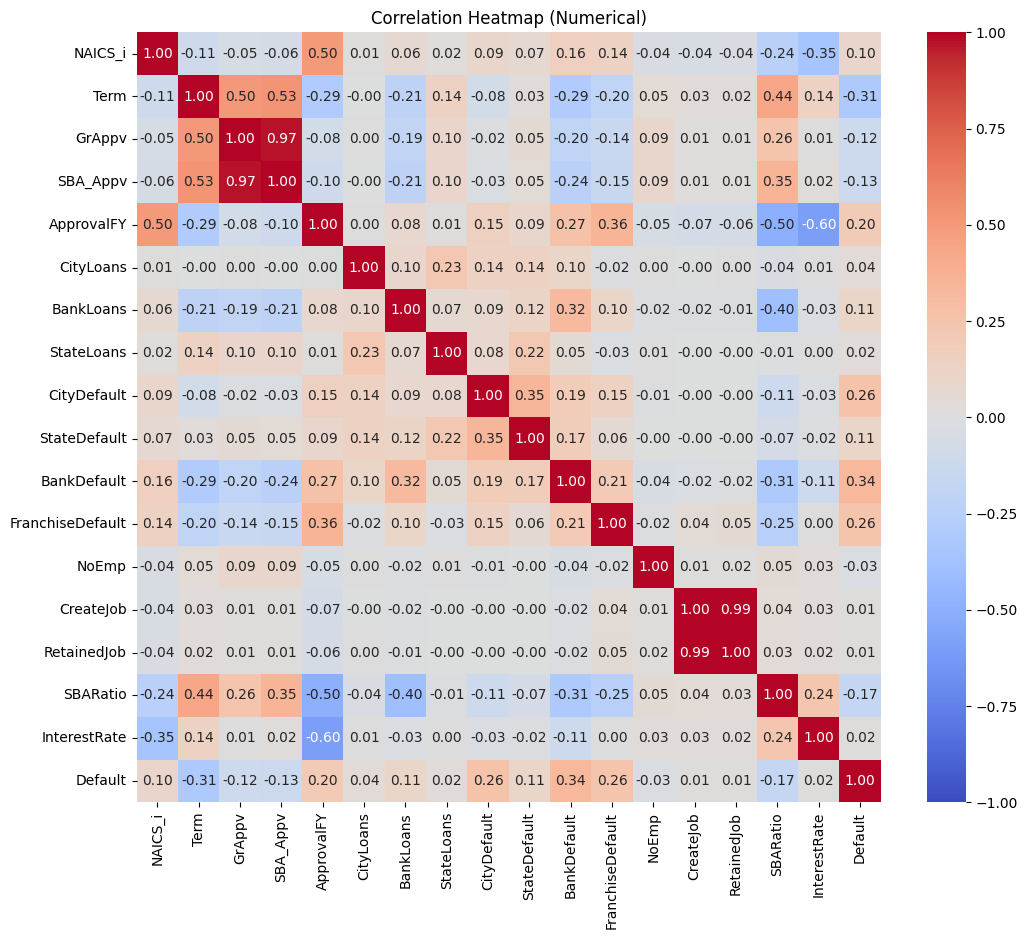

In [75]:
plt.figure(figsize=(12, 10))

# Calculate correlation matrix
numeric_corr = df_testing[numerical_features + [target]].corr()

# Generate heatmap
sns.heatmap(numeric_corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Numerical)')
plt.show()


In [76]:
for cat_feature in cat_features:
    print(f"\nCrosstab of {cat_feature}")
    cross_tab = pd.crosstab(df_testing[cat_feature], df_testing[target])
    cross_tab['Ratio'] = cross_tab[1] / cross_tab.sum(axis=1)
    print(cross_tab)


Crosstab of isNewBusiness
Default             0       1  Ratio
isNewBusiness                       
0.000          519556  104054  0.167
1.000          200236   45135  0.184

Crosstab of isFranchise
Default           0       1  Ratio
isFranchise                       
0            676736  141471  0.173
1             43056    7718  0.152

Crosstab of UrbanRural
Default          0       1  Ratio
UrbanRural                       
0           291426   22561  0.072
1           345148  107724  0.238
2            83218   18904  0.185

Crosstab of RevLineCr
Default         0      1  Ratio
RevLineCr                      
0          570892  98437  0.147
1          148900  50752  0.254

Crosstab of LowDoc
Default       0       1  Ratio
LowDoc                        
0        621874  139346  0.183
1         97918    9843  0.091


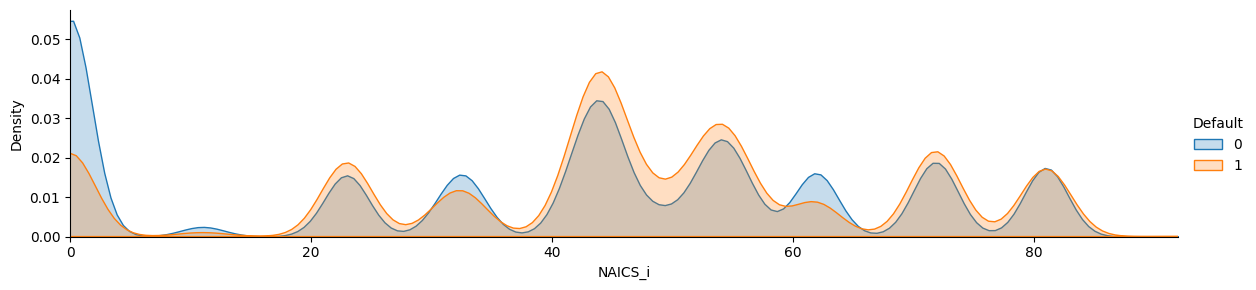

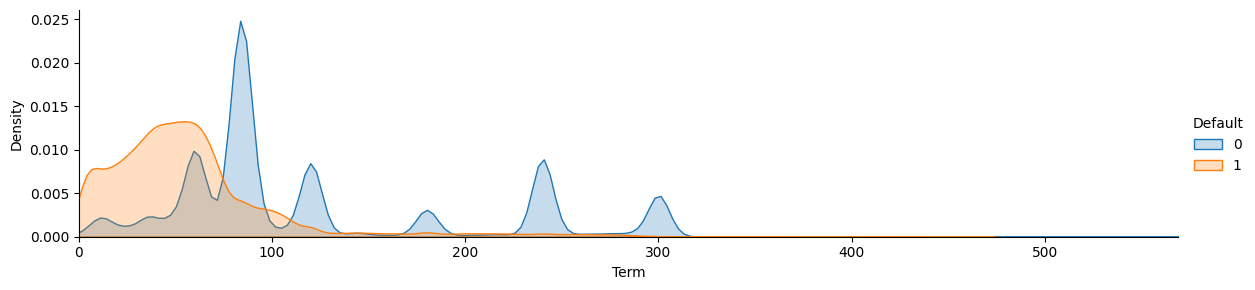

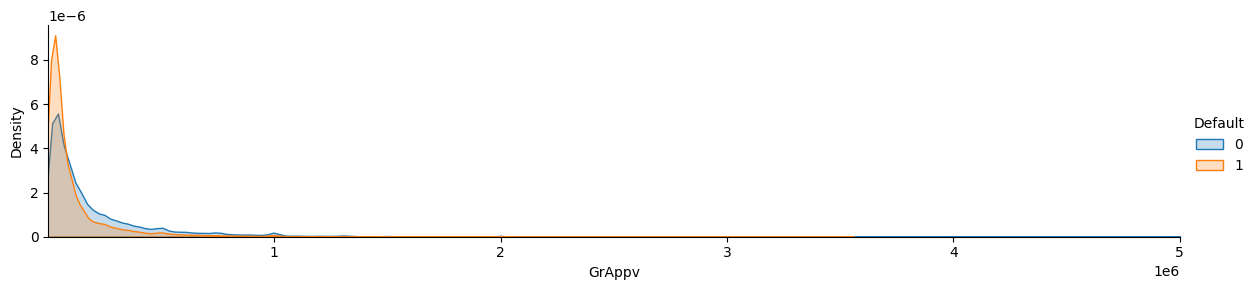

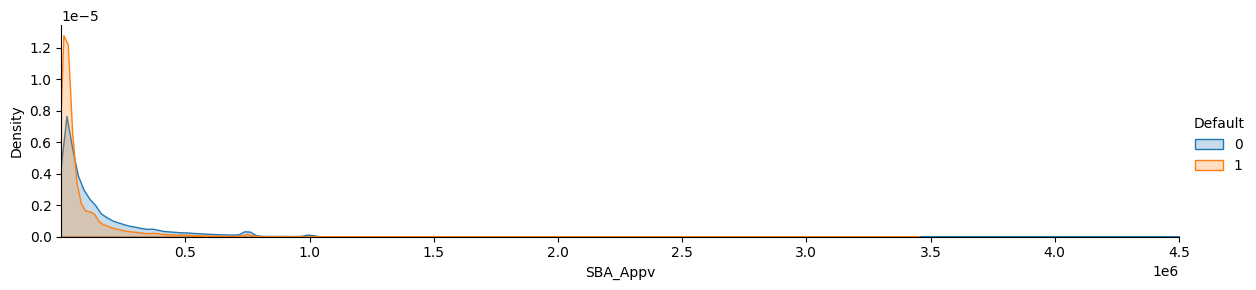

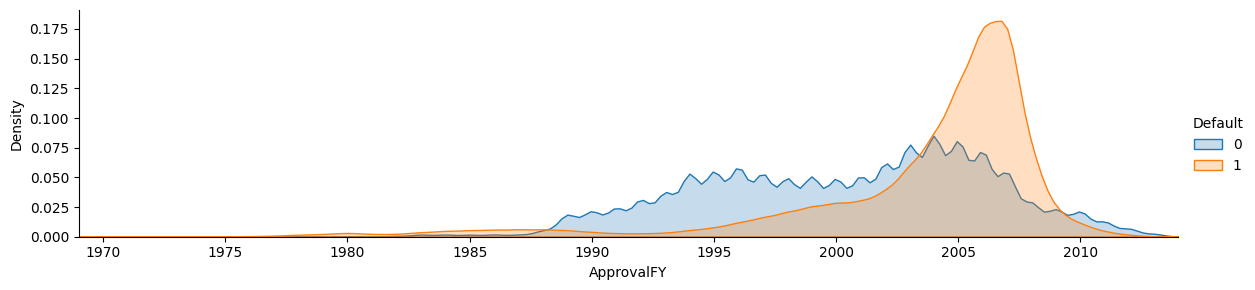

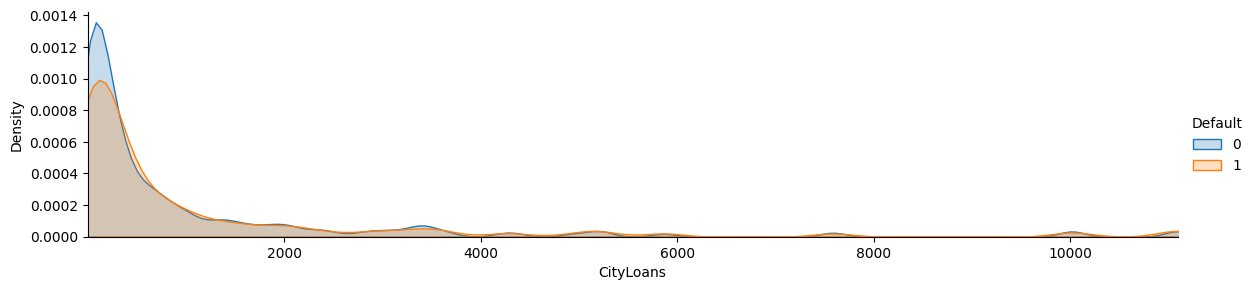

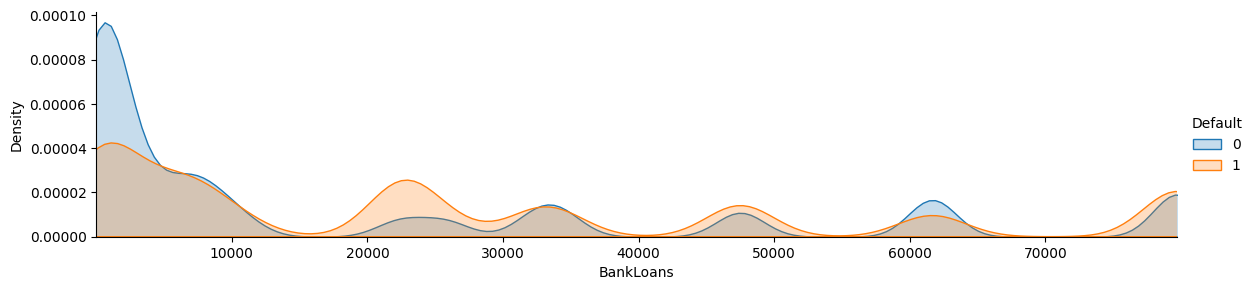

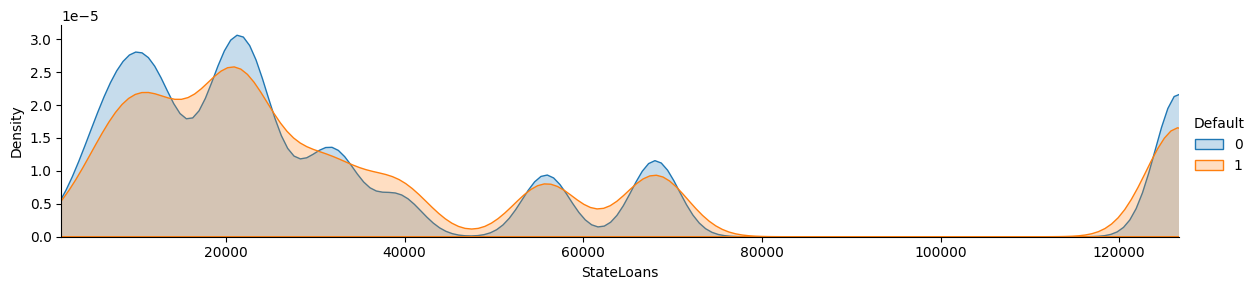

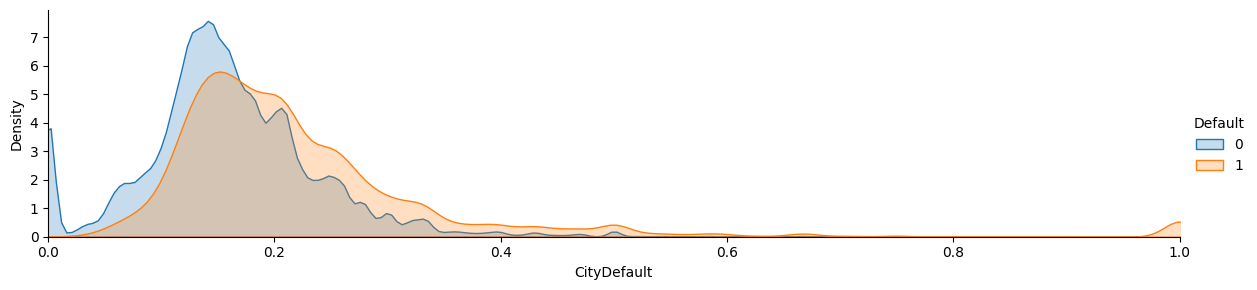

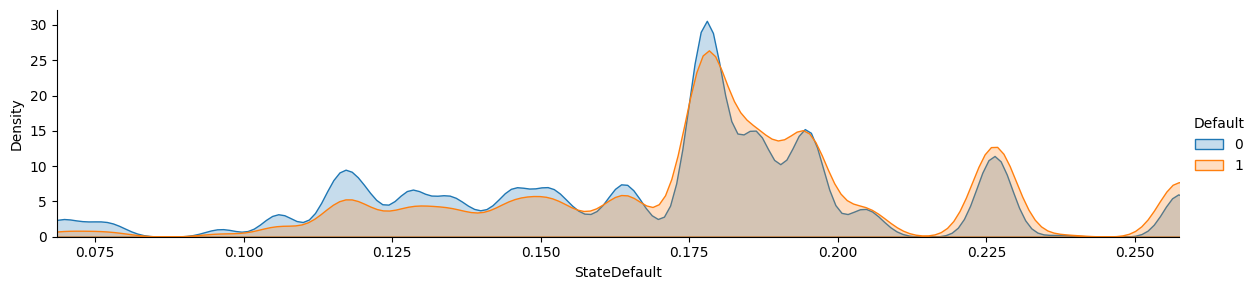

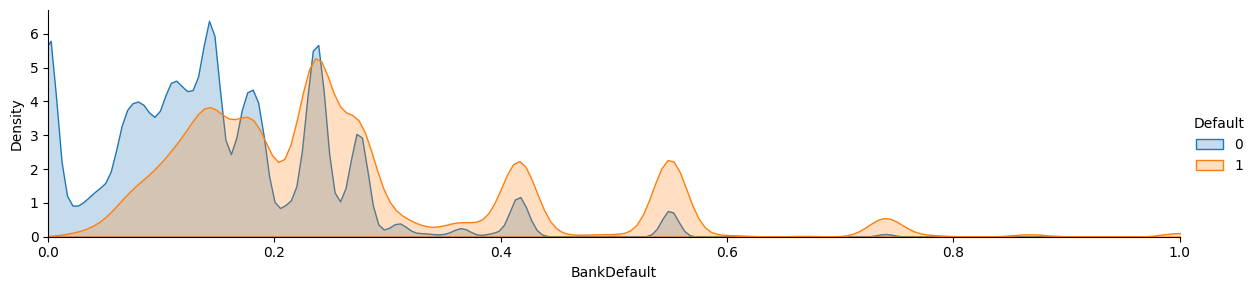

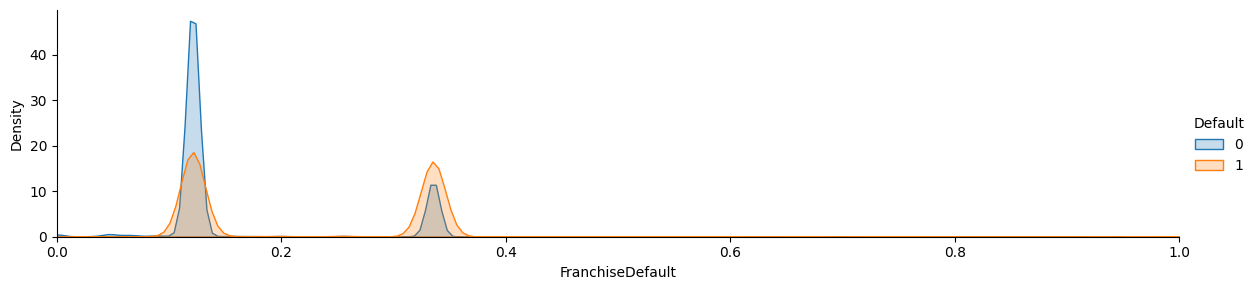

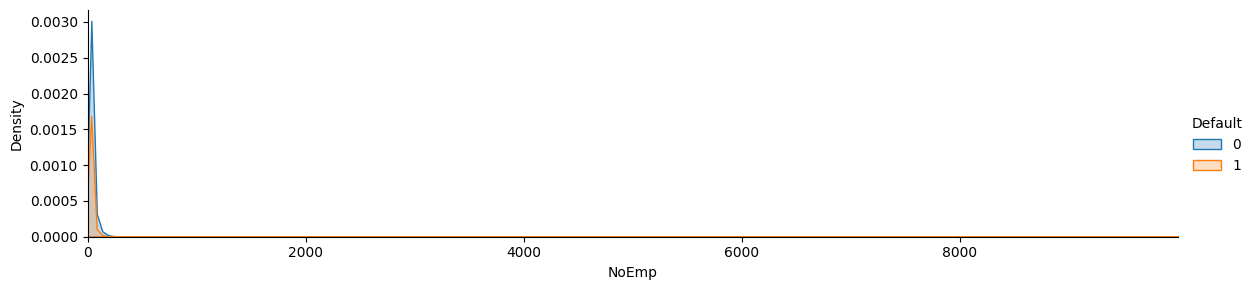

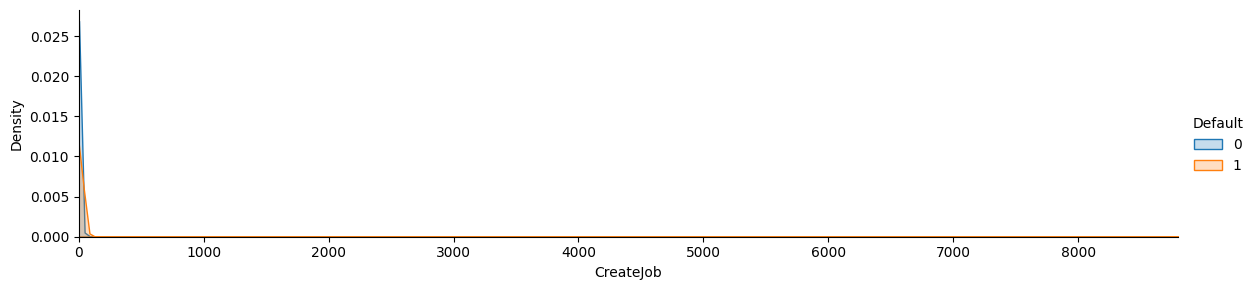

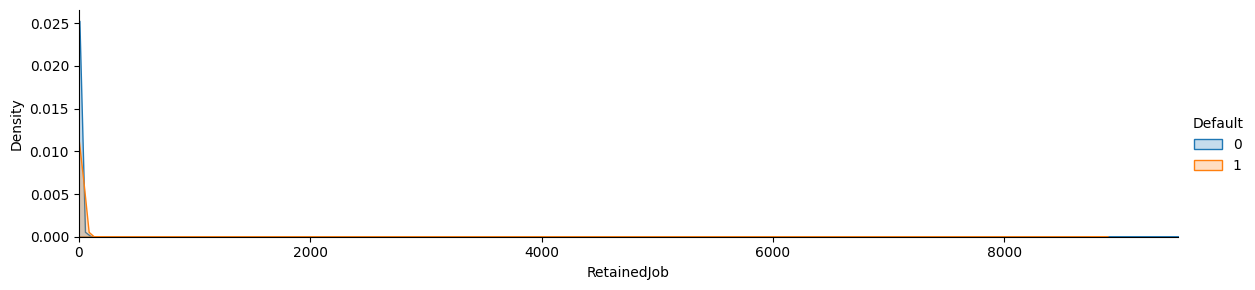

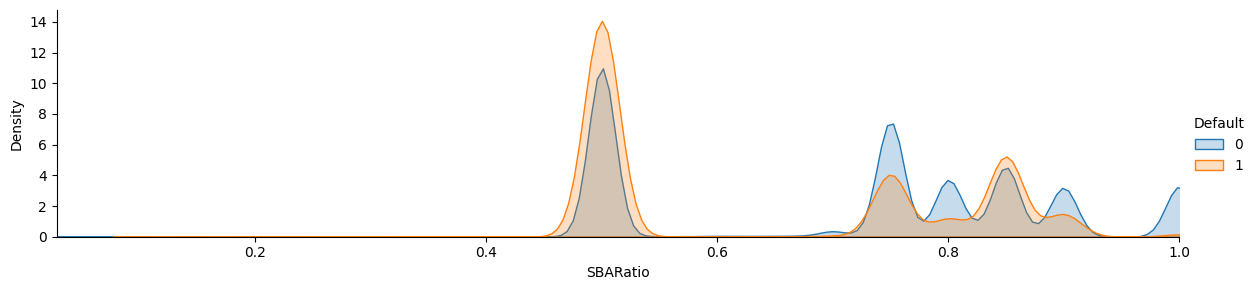

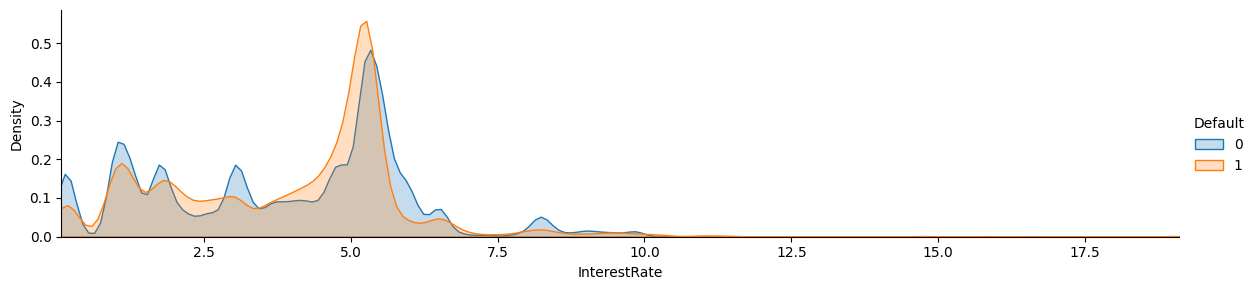

In [77]:
for num_feature in numerical_features:
    a = sns.FacetGrid( df_testing, hue = target, aspect=4 )
    a.map(sns.kdeplot, num_feature, fill= True )
    a.set(xlim=(df_testing[num_feature].min() , df_testing[num_feature].max()))
    a.add_legend()